In [65]:
# libraries
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from sklearn import neighbors
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [66]:
dataset_path = os.path.join(os.getcwd(), "regression_benchmark/data/capacitance_data.csv")
df = pd.read_csv(dataset_path)

In [67]:
df.drop(columns=['DOI'], inplace=True)

In [68]:
df.describe()

,Voltage window (V),Specific surface area (m2/g),Pore size (nm),Id/Ig,N (at. %),O (at. %),Capacitance (F/g)
count,141.000000,141.00000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,1.121986,1334.90461,2.169433,1.338674,1.954872,5.813560,212.341631
std,0.600130,862.12010,1.517926,0.727288,2.835795,6.007753,93.319707
min,0.600000,102.60000,0.460000,0.500000,0.000000,0.000000,1.900000
25%,0.900000,648.00000,0.900000,0.920000,0.000000,0.000000,150.000000
50%,1.000000,1264.00000,1.960000,1.020000,0.630000,4.735000,220.000000
75%,1.000000,1841.00000,3.000000,1.530000,2.900000,9.000000,275.000000
max,4.000000,3384.30000,8.370000,4.540000,10.969000,25.070000,440.000000


In [69]:
df.head()

,Materials-1,Materials-2,Voltage window (V),Specific surface area (m2/g),Pore size (nm),Id/Ig,N (at. %),O (at. %),Capacitance (F/g)
0,N-doped graphene,NaN,1.0,171.56,3.95,0.50,2.90,6.40,270.0
1,rgo,NaN,0.8,102.60,3.37,0.53,0.00,0.00,251.7
2,AC,NaN,0.9,2490.00,2.50,0.55,0.00,0.00,283.0
3,N-doped porous carbon,NaN,1.0,654.00,4.38,0.67,5.89,8.63,243.0
4,N-doped porous carbon,graphene,1.0,498.50,1.10,0.71,4.11,15.93,238.0


## Apply Encodings

In [70]:
# Replace empty strings and NaNs with a special placeholder
df["Materials-2"] = df["Materials-2"].replace('', np.nan)
df["Materials-2"] = df["Materials-2"].fillna('__MISSING__')

# Fit encoder
encoder = OrdinalEncoder()
df[["Materials-2"]] = encoder.fit_transform(df[["Materials-2"]])

# Get the index of the placeholder
missing_index = encoder.categories_[0].tolist().index('__MISSING__')

# Subtract 1 from all values > missing_index to shift them down
df["Materials-2"] = df["Materials-2"].apply(lambda x: 0 if x == missing_index else (x - 1 if x > missing_index else x))

In [71]:
# Fit encoder
encoder = OrdinalEncoder()
df["Materials-1"] = encoder.fit_transform(df[["Materials-1"]])

In [72]:
df.describe()

,Materials-1,Materials-2,Voltage window (V),Specific surface area (m2/g),Pore size (nm),Id/Ig,N (at. %),O (at. %),Capacitance (F/g)
count,140.000000,141.000000,141.000000,141.00000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,11.521429,0.198582,1.121986,1334.90461,2.169433,1.338674,1.954872,5.813560,212.341631
std,5.423726,0.709324,0.600130,862.12010,1.517926,0.727288,2.835795,6.007753,93.319707
min,0.000000,0.000000,0.600000,102.60000,0.460000,0.500000,0.000000,0.000000,1.900000
25%,8.750000,0.000000,0.900000,648.00000,0.900000,0.920000,0.000000,0.000000,150.000000
50%,12.000000,0.000000,1.000000,1264.00000,1.960000,1.020000,0.630000,4.735000,220.000000
75%,17.000000,0.000000,1.000000,1841.00000,3.000000,1.530000,2.900000,9.000000,275.000000
max,19.000000,3.000000,4.000000,3384.30000,8.370000,4.540000,10.969000,25.070000,440.000000


## Remove Missing Values

In [73]:
print(df.isnull().sum()) # check for missing values

Materials-1                     1
Materials-2                     0
Voltage window (V)              0
Specific surface area (m2/g)    0
Pore size (nm)                  0
Id/Ig                           0
N (at. %)                       0
O (at. %)                       0
Capacitance (F/g)               0
dtype: int64


In [74]:
df.dropna(inplace=True) # drop rows with missing values

In [75]:
print(df.isnull().sum()) # check for missing values

Materials-1                     0
Materials-2                     0
Voltage window (V)              0
Specific surface area (m2/g)    0
Pore size (nm)                  0
Id/Ig                           0
N (at. %)                       0
O (at. %)                       0
Capacitance (F/g)               0
dtype: int64


## Pairwise Plot


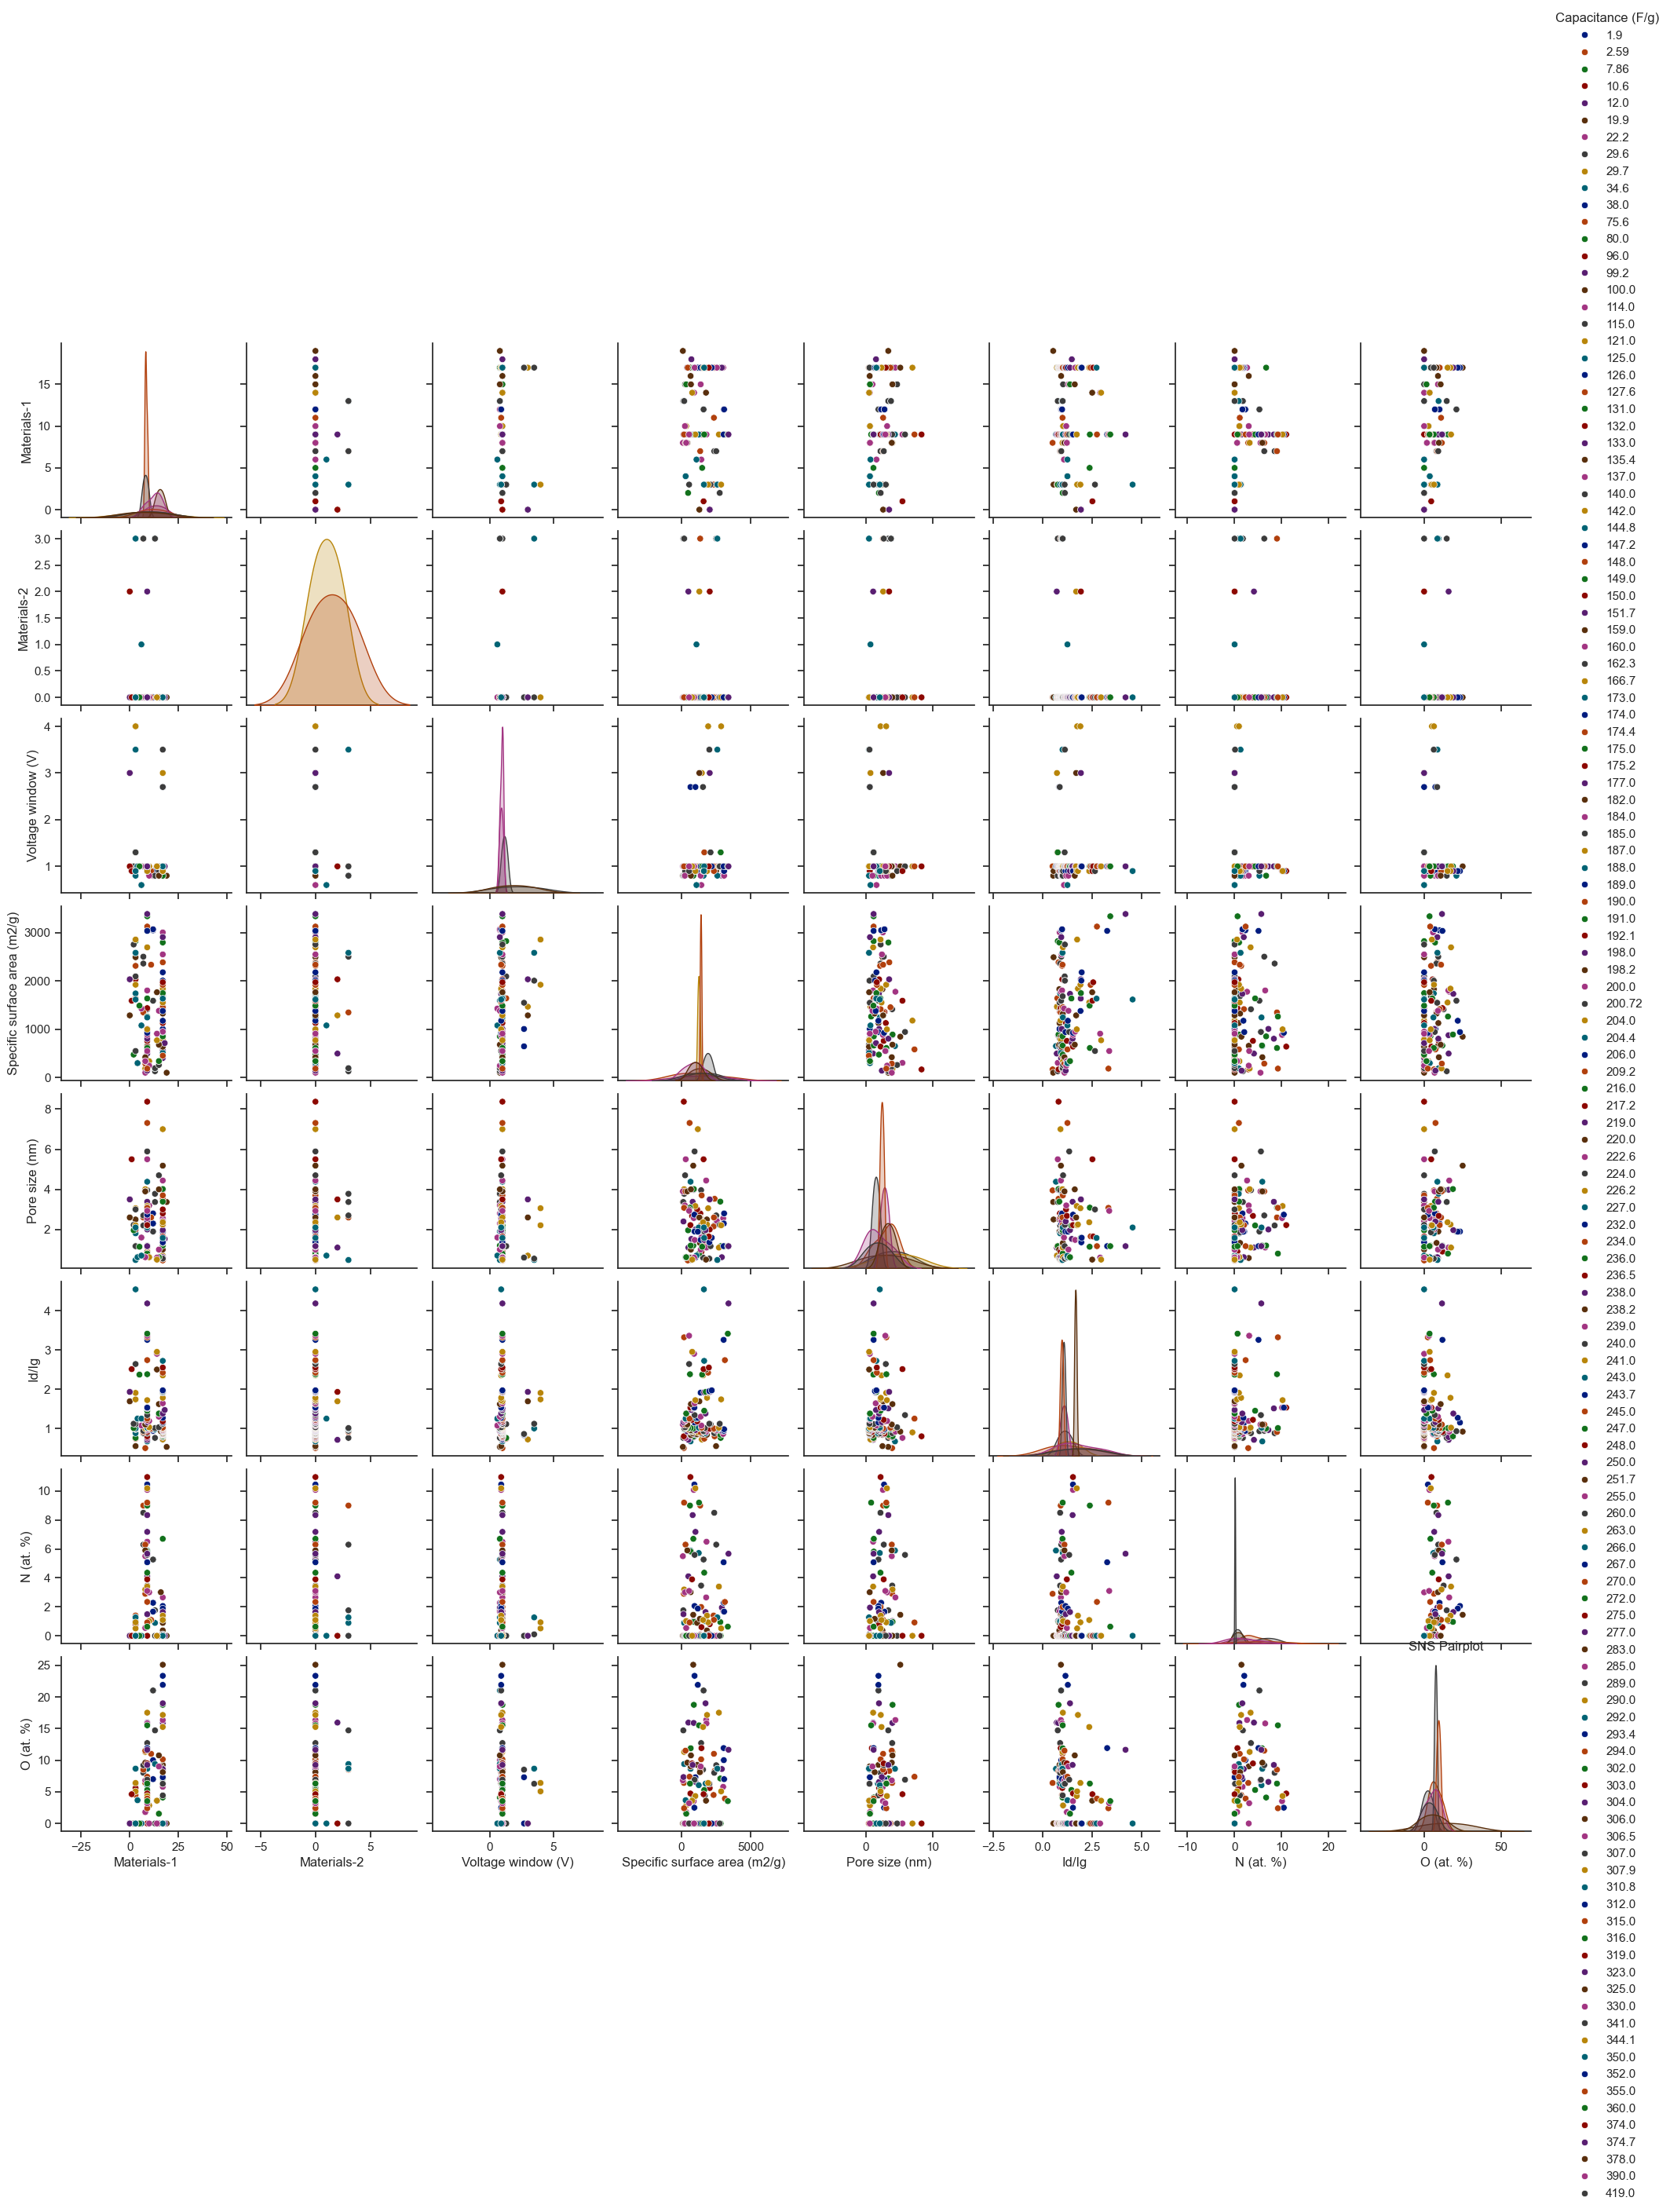

In [76]:
sns.pairplot(df, hue='Capacitance (F/g)', diag_kind='kde', palette='dark')  
plt.title('SNS Pairplot') 
plt.show()

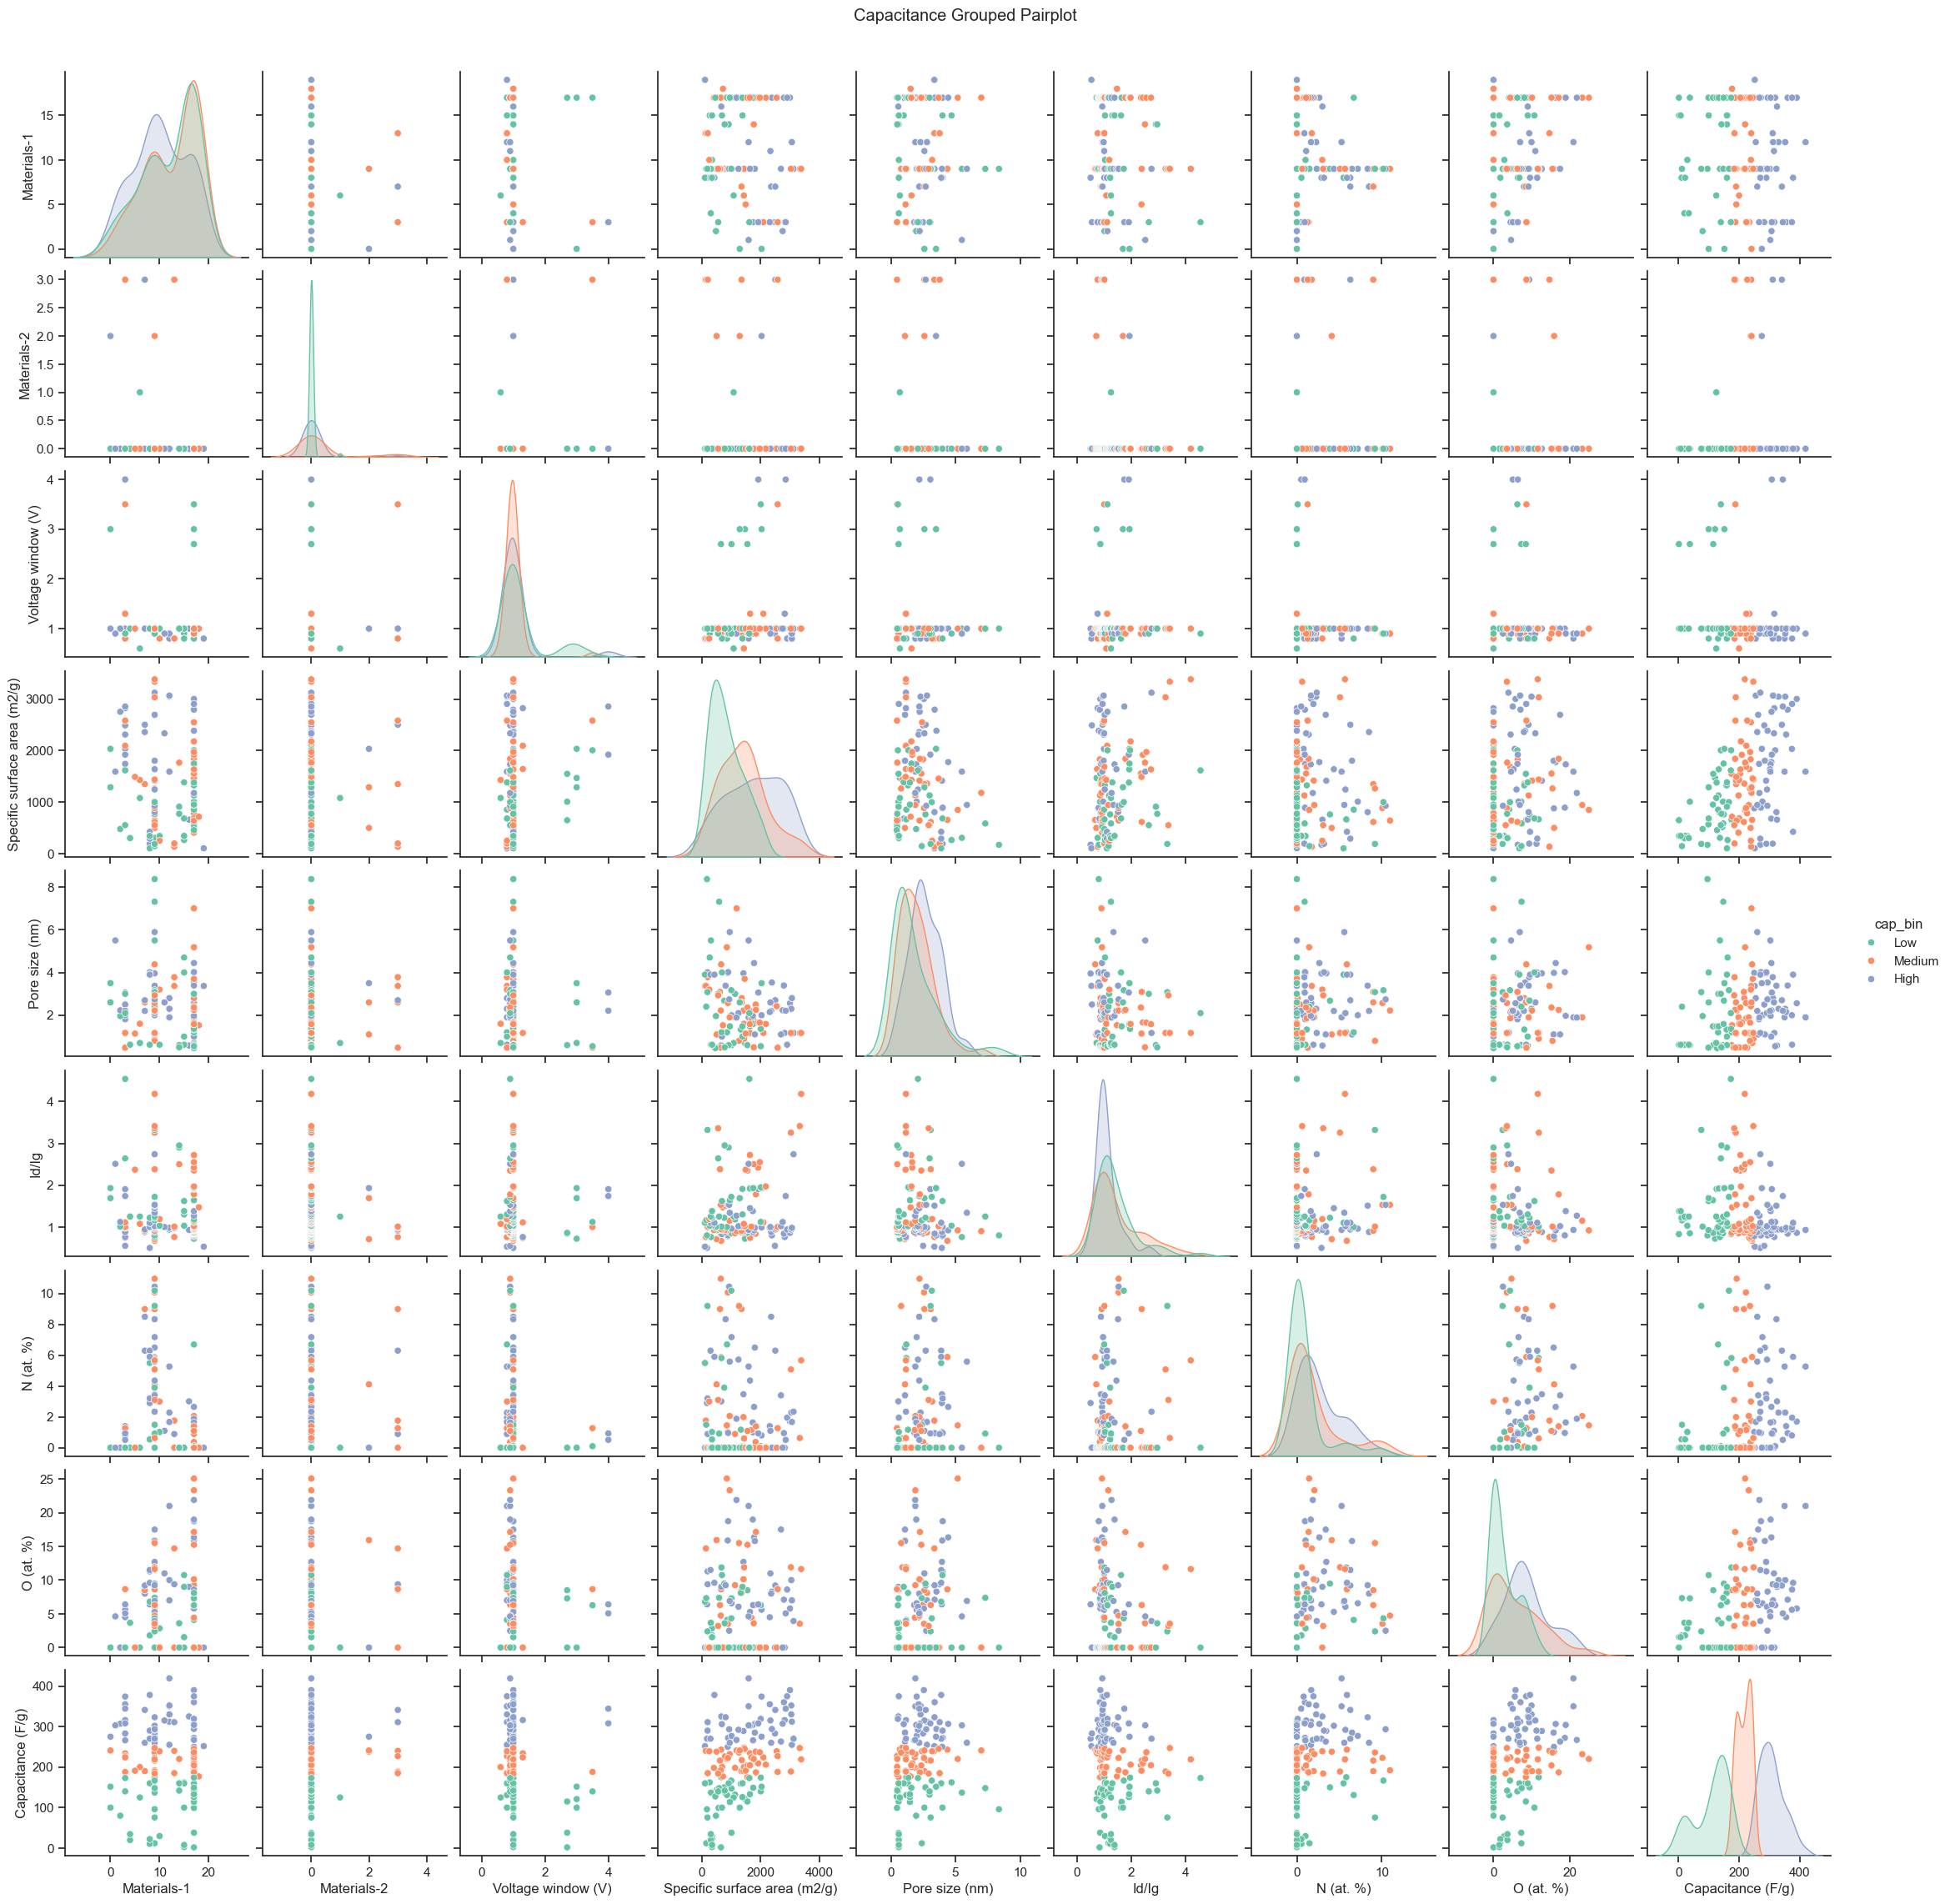

In [77]:
df['cap_bin'] = pd.qcut(df['Capacitance (F/g)'], q=3, labels=['Low', 'Medium', 'High'])

sns.pairplot(df, hue='cap_bin', diag_kind='kde', palette='Set2')
plt.suptitle('Capacitance Grouped Pairplot', y=1.02)
plt.show()

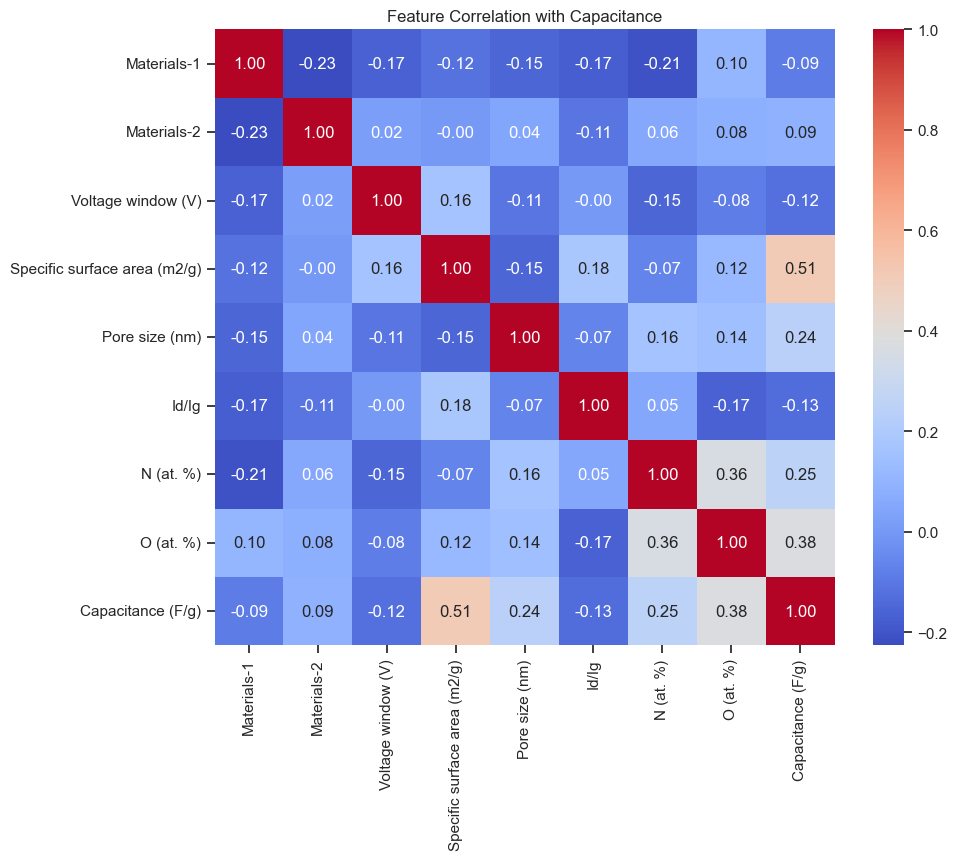

In [78]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation with Capacitance")
plt.show()

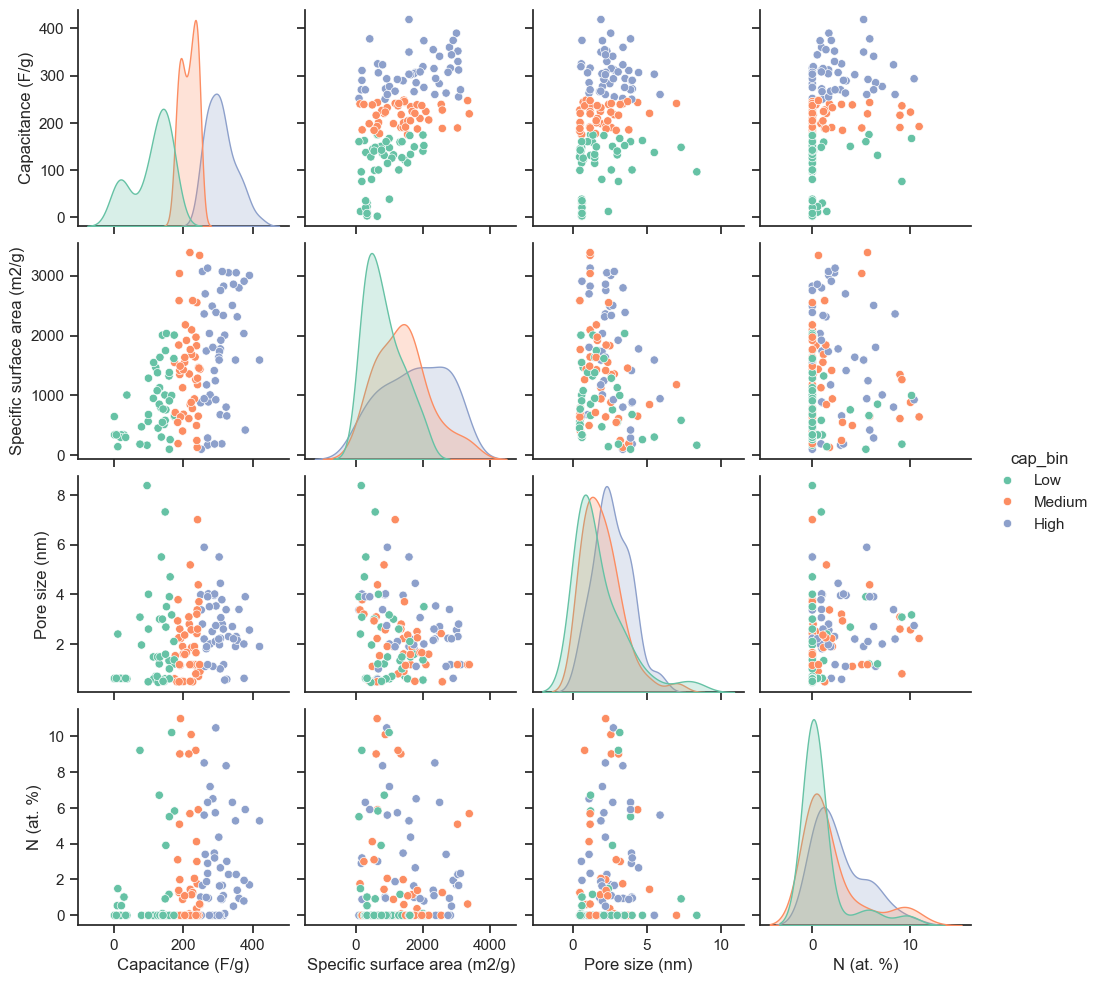

In [79]:
subset = ['Capacitance (F/g)', 'Specific surface area (m2/g)', 'Pore size (nm)', 'N (at. %)', 'cap_bin']
sns.pairplot(df[subset], hue='cap_bin', diag_kind='kde', palette='Set2')

Strong linear corellation between 'Capacitance (F/g)' and 'Specific surface area (m2/g)', 'Pore size (nm)', 'N (at. %)' is observed with respect to Capacitance Bins.
Specific surface area (m2/g)' shows the highest correlation

In [80]:
df.drop(columns=['cap_bin'], inplace=True)

## Identifying Outliers

In [81]:
skewness = df.skew()
kurtosis = df.kurtosis()

print("Skewness: \n", skewness)
print("\n\n")
print("Kurtosis: \n", kurtosis)

Skewness: 
 Materials-1                    -0.456492
Materials-2                     3.455240
Voltage window (V)              3.508418
Specific surface area (m2/g)    0.540674
Pore size (nm)                  1.278875
Id/Ig                           1.994833
N (at. %)                       1.614602
O (at. %)                       1.021065
Capacitance (F/g)              -0.303066
dtype: float64



Kurtosis: 
 Materials-1                     -1.031957
Materials-2                     10.473714
Voltage window (V)              11.619238
Specific surface area (m2/g)    -0.625837
Pore size (nm)                   2.257211
Id/Ig                            4.171774
N (at. %)                        1.638370
O (at. %)                        0.569787
Capacitance (F/g)               -0.210241
dtype: float64


Since we encoded 'Materials-1' and 'Materials-2' we will ignore them for our current analysis
'Voltage window (V)' shows high positive skew indicating a long tail on the right. It also shows a high postiive kurtosis value indicating that there is a heavy tail. This highlights possible outliers in this feature.
'Id/Ig' shows a high positive kurtosis value indicating a heavy right tail.

We will apply log transformations to 'Voltage window (V)' and 'Id/Ig' and then apply z-score normalization

In [82]:
df.columns = df.columns.str.strip()  # Clean column names

# === Configuration ===
target_col = 'Capacitance (F/g)'
log_transform_cols = ['Voltage window (V)', 'Id/Ig']
numeric_cols = ['Voltage window (V)', 'Specific surface area (m2/g)', 'Pore size (nm)', 'Id/Ig', 'N (at. %)', 'O (at. %)']
output_path = os.path.join(os.getcwd(), "regression_benchmark/data")
os.makedirs(output_path, exist_ok=True)

# === Step 1: Train/test split (RAW) ===
X = df.drop(columns=[target_col])
y = df[target_col]
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

# Save raw train/test data
X_train_raw[target_col] = y_train_raw
X_test_raw[target_col] = y_test_raw
X_train_raw.to_csv(os.path.join(output_path, "train_raw.csv"), index=False)
X_test_raw.to_csv(os.path.join(output_path, "test_raw.csv"), index=False)

# === Shared log transform function ===
def log_transform(df_part):
    df_copy = df_part.copy()
    for col in log_transform_cols:
        if col in df_copy.columns:
            df_copy[col] = np.log1p(df_copy[col])
    return df_copy

# === Step 2: Scaled (no outlier removal) ===
X_train_logged = log_transform(X_train_raw)
X_test_logged = log_transform(X_test_raw)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_logged[numeric_cols])
X_test_scaled = scaler.transform(X_test_logged[numeric_cols])

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['Scaled_' + col for col in numeric_cols], index=X_train_raw.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['Scaled_' + col for col in numeric_cols], index=X_test_raw.index)

X_train_scaled_df[target_col] = y_train_raw.values
X_test_scaled_df[target_col] = y_test_raw.values

X_train_scaled_df.to_csv(os.path.join(output_path, "train_scaled.csv"), index=False)
X_test_scaled_df.to_csv(os.path.join(output_path, "test_scaled.csv"), index=False)

# === Step 3: Scaled (after outlier removal on train only) ===
z_scores = np.abs(zscore(X_train_raw[numeric_cols], nan_policy='omit'))
threshold = 3
outlier_mask = (z_scores > threshold).any(axis=1)

X_train_cleaned = X_train_raw[~outlier_mask].drop(columns=[target_col])
y_train_cleaned = y_train_raw[~outlier_mask]

X_train_logged = log_transform(X_train_cleaned)
X_test_logged = log_transform(X_test_raw)

X_train_scaled = scaler.fit_transform(X_train_logged[numeric_cols])
X_test_scaled = scaler.transform(X_test_logged[numeric_cols])

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['Scaled_' + col for col in numeric_cols], index=X_train_cleaned.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['Scaled_' + col for col in numeric_cols], index=X_test_raw.index)

X_train_scaled_df[target_col] = y_train_cleaned.values
X_test_scaled_df[target_col] = y_test_raw.values

X_train_scaled_df.to_csv(os.path.join(output_path, "train_scaled_removed_outliers.csv"), index=False)
X_test_scaled_df.to_csv(os.path.join(output_path, "test_scaled_removed_outliers.csv"), index=False)

Copies of the test train split are saved with and without outliers. The goal is to train/test both datasets to determine the best pre processing approach for such datasets. Lastly, we will also test the raw dataset without any scaling or outlier removal as baseline.